# Conditional Autoencoder for Asset Pricing - Part 2: The Model

This notebook uses a dataset created using `yfinance` in the notebook [conditional_autoencoder_for_asset_pricing_data](05_conditional_autoencoder_for_asset_pricing_data.ipynb). The results will vary depending on which ticker downloads succeeded.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys, os
from time import time
from pathlib import Path
from itertools import product
from tqdm import tqdm 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dot, Reshape, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard

from sklearn.preprocessing import quantile_transform

from scipy.stats import spearmanr

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [4]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [5]:
idx = pd.IndexSlice
sns.set_style('whitegrid')
np.random.seed(42)

In [6]:
results_path = Path('results', 'asset_pricing')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [9]:
characteristics = ['beta', 'betasq', 'chmom', 'dolvol', 'idiovol', 'ill', 'indmom',
                   'maxret', 'mom12m', 'mom1m', 'mom36m', 'mvel', 'retvol', 'turn', 'turn_std']

## Load Data

In [9]:
with pd.HDFStore(results_path / 'autoencoder.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: results\asset_pricing\autoencoder.h5
/close                      frame        (shape->[7559,3903])
/factor/beta                frame        (shape->[2714104,1])
/factor/betasq              frame        (shape->[2714104,1])
/factor/chmom               frame        (shape->[3074312,1])
/factor/dolvol              frame        (shape->[3238902,1])
/factor/idiovol             frame        (shape->[2714104,1])
/factor/ill                 frame        (shape->[2915413,1])
/factor/indmom              frame        (shape->[3226879,1])
/factor/maxret              frame        (shape->[3239639,1])
/factor/mom12m              frame        (shape->[3074312,1])
/factor/mom1m               series       (shape->[3255712])  
/factor/mom36m              frame        (shape->[2712385,1])
/factor/mvel                frame        (shape->[3272588,1])
/factor/retvol              frame        (shape->[3255712,1])
/factor/turn                frame        (shap

### Weekly returns

In [10]:
data = (pd.read_hdf(results_path / 'autoencoder.h5', 'returns')
        .stack(dropna=False)
        .to_frame('returns')
        .loc[idx['1993':, :], :])

In [11]:
with pd.HDFStore(results_path / 'autoencoder.h5') as store:
    keys = [k[1:] for k in store.keys() if k[1:].startswith('factor')]
    for key in keys:
        data[key.split('/')[-1]] = store[key].squeeze()

In [12]:
data

returns      beta    betasq     chmom     dolvol  \
date       ticker                                                      
1993-01-01 A            NaN       NaN       NaN       NaN        NaN   
           AA      0.008803  1.240528  1.538909 -0.212555  16.414885   
           AADI         NaN       NaN       NaN       NaN        NaN   
           AAL          NaN       NaN       NaN       NaN        NaN   
           AAME   -0.133333  1.174631  1.379759  0.158730   9.521394   
...                     ...       ...       ...       ...        ...   
2020-01-03 ZUO     0.008445       NaN       NaN  0.030341  16.181731   
           ZVRA   -0.093301  1.711171  2.928107 -0.718225  11.574332   
           ZWS    -0.002447  1.610193  2.592721 -0.228622  17.294971   
           ZYME    0.018141       NaN       NaN  0.327639  16.478268   
           ZYXI   -0.022360  0.322939  0.104290 -2.334258  14.762869   

                    idiovol           ill    indmom    maxret    mom12m  \
date       ticker                                                         
1993-01-01 A            NaN           NaN       NaN       NaN       NaN   
           AA      0.031356  6.342770e-10  0.243519  0.111111  0.124598   
           AADI         NaN           NaN       NaN       NaN       NaN   
           AAL          NaN           NaN       NaN       NaN       NaN   
           AAME    0.158507           NaN  0.271826  1.133334  1.285715   
...                     ...           ...       ...       ...       ...   
2020-01-03 ZUO          NaN  1.039630e-09  0.408955  0.077352 -0.121279   
           ZVRA    0.102609  4.215338e-07  0.234536 -0.066667 -0.747191   
           ZWS     0.027937  3.701036e-10  0.292684  0.102863  0.376471   
           ZYME         NaN  1.518846e-09  0.234536  0.245832  1.969346   
           ZYXI    0.100009  1.309303e-08  0.234536  0.154095  2.571429   

                      mom1m    mom36m       mvel    retvol      turn  turn_std  
date       ticker                                                               
1993-01-01 A            NaN       NaN        NaN       NaN       NaN       NaN  
           AA      0.008803 -0.078046  21.898131  0.009718  0.005255  0.002185  
           AADI         NaN       NaN        NaN       NaN       NaN       NaN  
           AAL          NaN       NaN        NaN       NaN       NaN       NaN  
           AAME   -0.187500 -0.631579  17.467968  0.067069  0.000380  0.000363  
...                     ...       ...        ...       ...       ...       ...  
2020-01-03 ZUO    -0.101004       NaN  20.958341  0.023892  0.006947  0.003470  
           ZVRA   -0.157778 -0.416393  19.270552  0.093025  0.000593  0.001485  
           ZWS     0.032605  0.163203  22.349384  0.009281  0.005607  0.001684  
           ZYME    0.042900       NaN  20.371607  0.028967  0.004906  0.002637  
           ZYXI   -0.250476  8.175704  19.698836  0.040804  0.013021  0.005922  

[5503230 rows x 16 columns]

In [13]:
characteristics = data.drop('returns', axis=1).columns.tolist()

In [14]:
data['returns_fwd'] = data.returns.unstack('ticker').shift(-1).stack()

In [15]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5503230 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'A') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYXI')
Data columns (total 17 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   returns      3134139 non-null  float64
 1   beta         2714104 non-null  float64
 2   betasq       2714104 non-null  float64
 3   chmom        2987263 non-null  float64
 4   dolvol       3111149 non-null  float64
 5   idiovol      2714104 non-null  float64
 6   ill          2818017 non-null  float64
 7   indmom       3134139 non-null  float64
 8   maxret       3111886 non-null  float64
 9   mom12m       2987263 non-null  float64
 10  mom1m        3124070 non-null  float64
 11  mom36m       2712385 non-null  float64
 12  mvel         3136988 non-null  float64
 13  retvol       3124070 non-null  float64
 14  turn         3098763 non-null  float64
 15  turn_std     3124398 non-null  fl

In [16]:
# number of observations
nobs_by_date = data.groupby(level='date').count().max(1)
nobs_by_characteristic = pd.melt(data[characteristics].groupby(level='date').count(),
                                 value_name='# Observations',
                                 var_name=['Characteristic'])

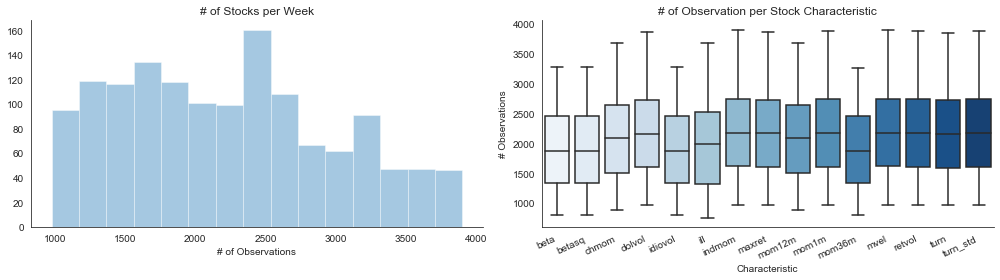

In [17]:
with sns.axes_style("white"):
    fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
    sns.distplot(nobs_by_date, kde=False, ax=axes[0])
    axes[0].set_title('# of Stocks per Week')
    axes[0].set_xlabel('# of Observations')
    sns.boxplot(x='Characteristic',
                y='# Observations',
                data=nobs_by_characteristic,
                ax=axes[1],
                palette='Blues')
    axes[1].set_xticklabels(axes[1].get_xticklabels(),
                            rotation=25,
                            ha='right')
    axes[1].set_title('# of Observation per Stock Characteristic')
    sns.despine()
    fig.tight_layout()

### Rank-normalize characteristics

In [18]:
data.loc[:, characteristics] = (data.loc[:, characteristics]
                                .groupby(level='date')
                                .apply(lambda x: pd.DataFrame(quantile_transform(x, 
                                                                                 copy=True, 
                                                                                 n_quantiles=x.shape[0]),
                                                              columns=characteristics,
                                                              index=x.index.get_level_values('ticker')))
                               .mul(2).sub(1))

In [19]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5503230 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'A') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), 'ZYXI')
Data columns (total 17 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   returns      3134139 non-null  float64
 1   beta         2714104 non-null  float64
 2   betasq       2714104 non-null  float64
 3   chmom        2987263 non-null  float64
 4   dolvol       3111149 non-null  float64
 5   idiovol      2714104 non-null  float64
 6   ill          2818017 non-null  float64
 7   indmom       3134139 non-null  float64
 8   maxret       3111886 non-null  float64
 9   mom12m       2987263 non-null  float64
 10  mom1m        3124070 non-null  float64
 11  mom36m       2712385 non-null  float64
 12  mvel         3136988 non-null  float64
 13  retvol       3124070 non-null  float64
 14  turn         3098763 non-null  float64
 15  turn_std     3124398 non-null  fl

In [20]:
data.index.names

FrozenList(['date', 'ticker'])

In [21]:
data.describe()

,returns,beta,betasq,chmom,dolvol,idiovol,ill,indmom,maxret,mom12m,mom1m,mom36m,mvel,retvol,turn,turn_std,returns_fwd
count,3.134139e+06,2.714104e+06,2.714104e+06,2.987263e+06,3.111149e+06,2.714104e+06,2.818017e+06,3.134139e+06,3.111886e+06,2.987263e+06,3.124070e+06,2.712385e+06,3.136988e+06,3.124070e+06,3.098763e+06,3.124398e+06,3.133164e+06
mean,3.013938e-03,-9.643197e-09,-4.738640e-07,-4.318933e-08,-9.826408e-07,-1.645693e-07,-4.866207e-07,-5.031345e-03,-1.050086e-07,-1.377338e-07,-2.663623e-08,-1.496132e-07,1.444871e-08,-7.412178e-07,-5.052648e-07,-8.259907e-07,3.011686e-03
std,6.203316e-02,5.776498e-01,5.776504e-01,5.776222e-01,5.776134e-01,5.776499e-01,5.776387e-01,5.965264e-01,5.776110e-01,5.776223e-01,5.776078e-01,5.776500e-01,5.776094e-01,5.776116e-01,5.776130e-01,5.776114e-01,6.203763e-02
min,-9.549180e-01,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-9.549180e-01
25%,-2.173368e-02,-5.002566e-01,-5.002570e-01,-5.002551e-01,-5.002511e-01,-5.002568e-01,-5.002555e-01,-4.923116e-01,-5.002528e-01,-5.002556e-01,-5.002236e-01,-5.002566e-01,-5.002485e-01,-5.002530e-01,-5.002567e-01,-5.002524e-01,-2.173876e-02
50%,8.941485e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.025115e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.944589e-04
75%,2.505041e-02,5.002570e-01,5.002570e-01,5.002525e-01,5.002499e-01,5.002565e-01,5.002557e-01,4.853921e-01,5.002516e-01,5.002545e-01,5.002558e-01,5.002565e-01,5.002494e-01,5.002526e-01,5.002568e-01,5.002533e-01,2.504955e-02
max,4.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00


In [22]:
data = data.loc[idx[:'2019', :], :]

In [23]:
data.loc[:, ['returns', 'returns_fwd']] = data.loc[:, ['returns', 'returns_fwd']].clip(lower=-1, upper=1.0)

In [24]:
data = data.fillna(-2)

In [25]:
data.to_hdf(results_path / 'autoencoder.h5', 'model_data')

## Architecture

In [7]:
data = pd.read_hdf(results_path / 'autoencoder.h5', 'model_data')

#### Model:网络的左侧将因子载荷作为协变量（如资产特征）的非线性函数来建模，而右侧网络将因子作为单个股票收益的组合来建模。
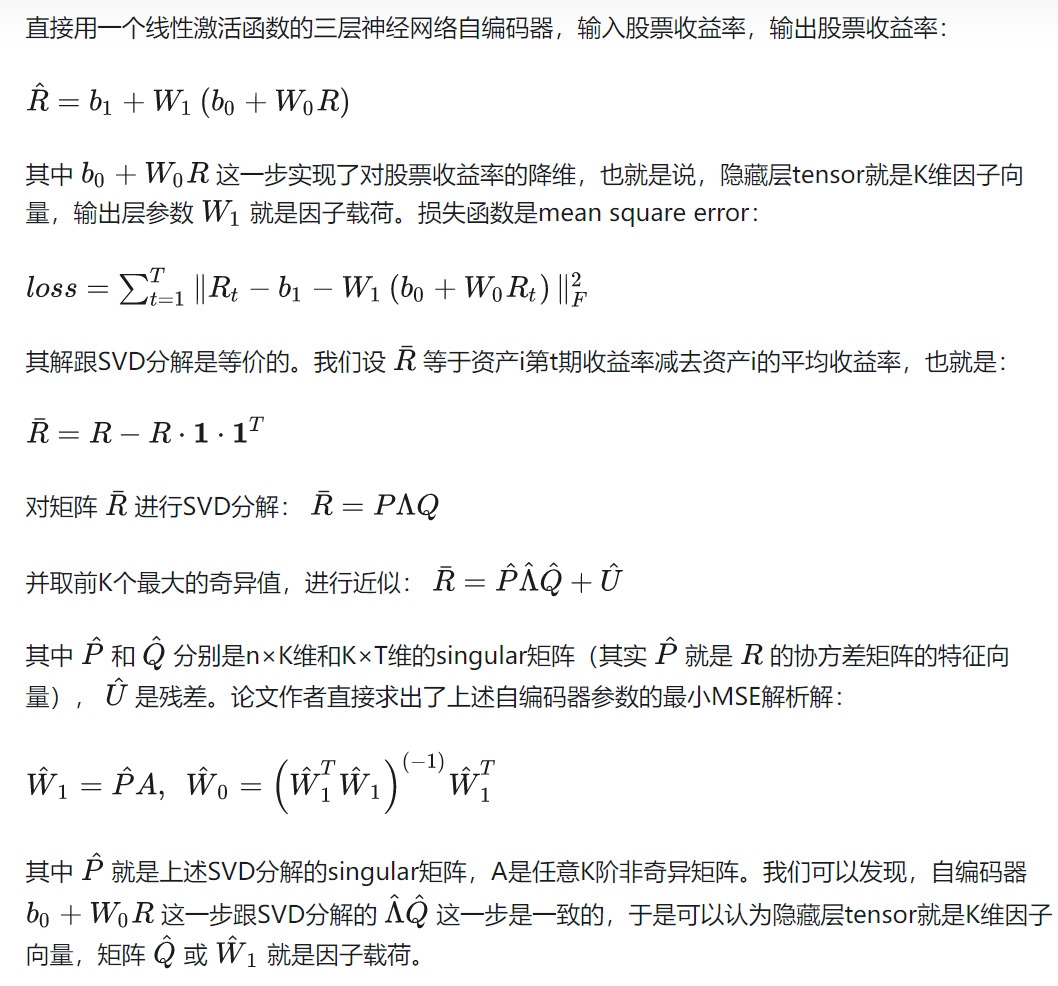
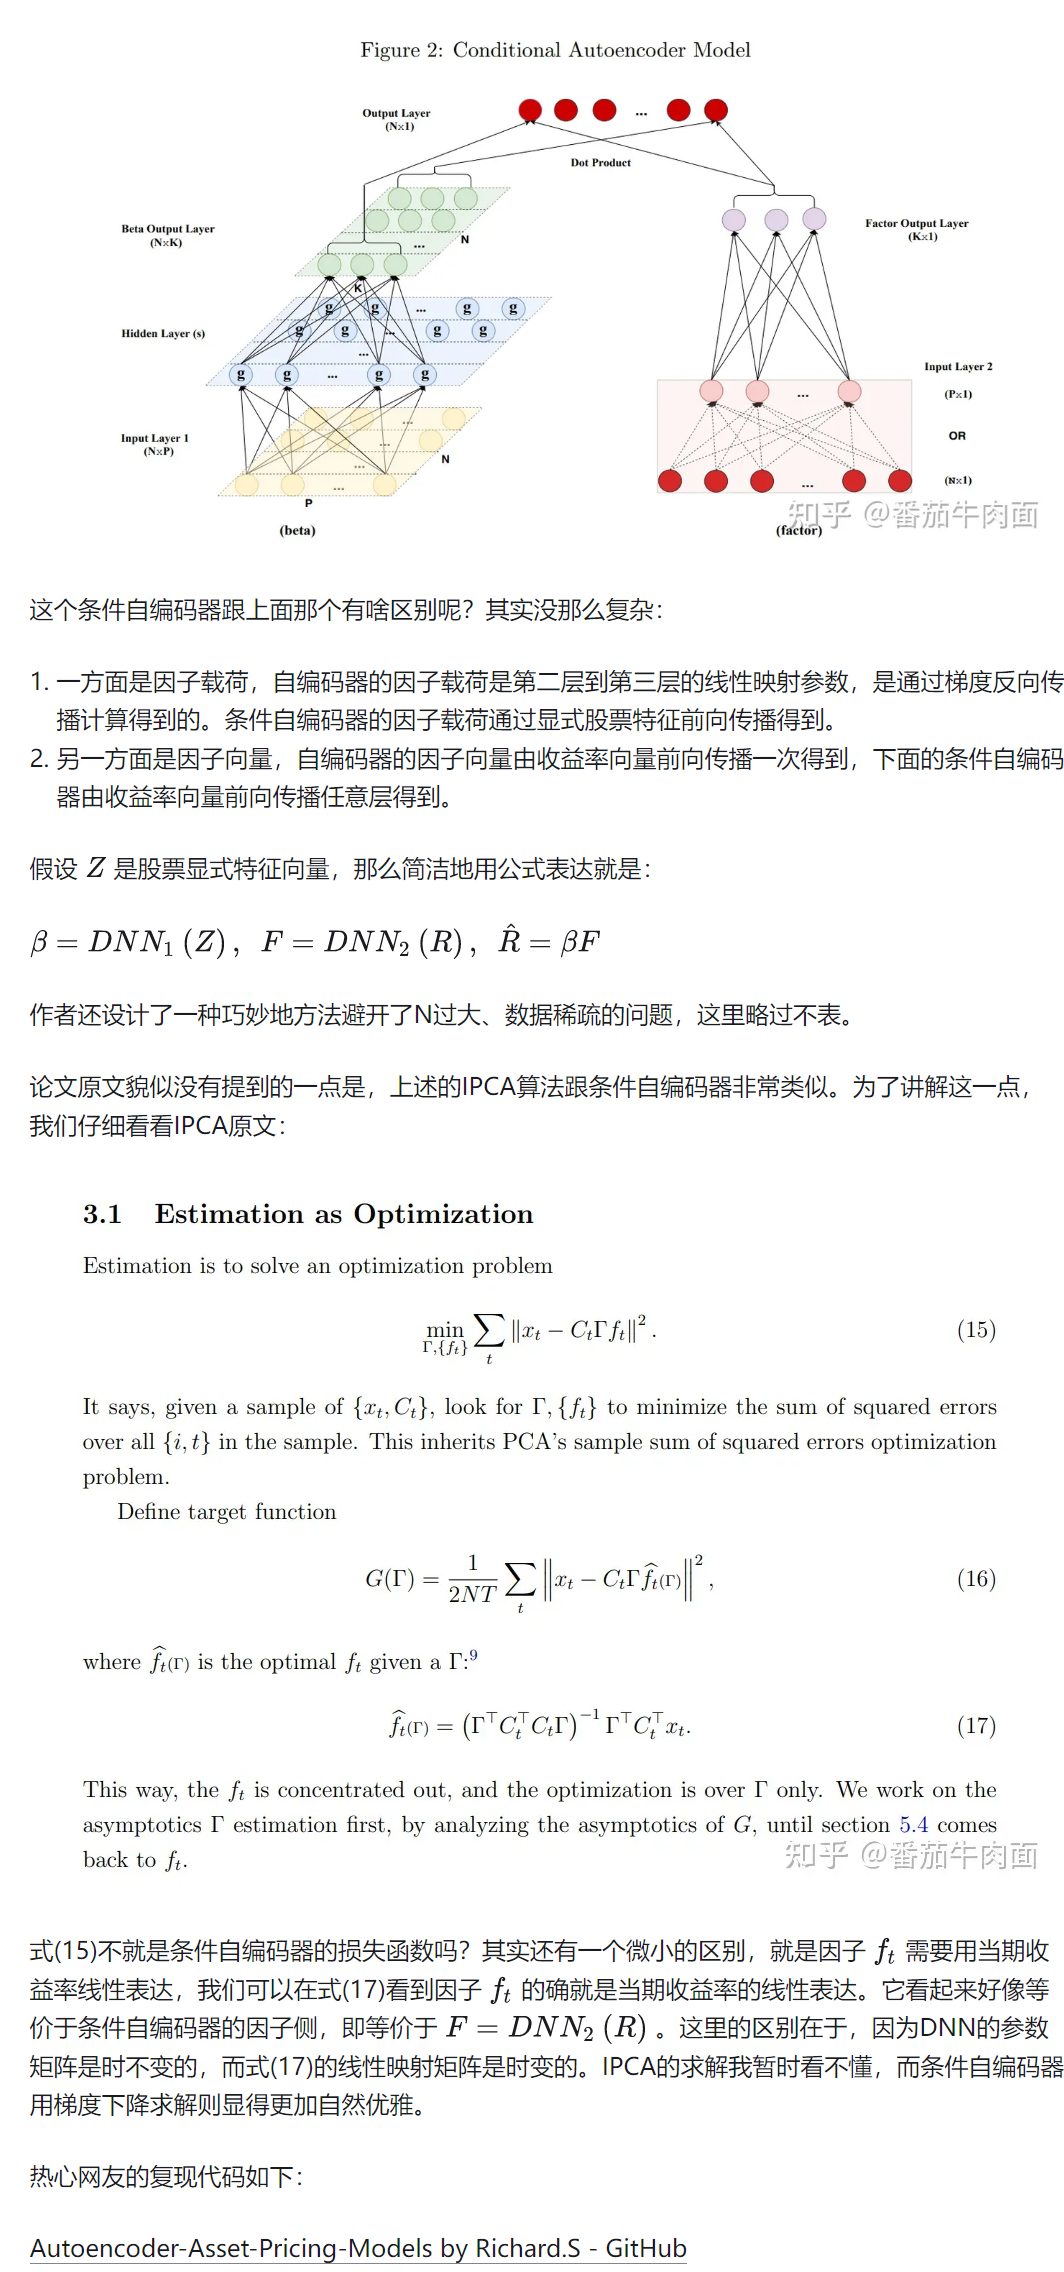

### Key parameters

In [10]:
n_factors = 3
n_characteristics = len(characteristics)
n_tickers = len(data.index.unique('ticker'))

In [29]:
n_tickers

3903

In [30]:
n_characteristics

15

### Input Layer

In [11]:
input_beta = Input((n_tickers, n_characteristics), name='input_beta')
input_factor = Input((n_tickers,), name='input_factor')

### Stock Characteristics Network

In [12]:
hidden_layer = Dense(units=8, activation='relu', name='hidden_layer')(input_beta)
batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)
output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)

### Factor Network

In [13]:
output_factor = Dense(units=n_factors, name='output_factor')(input_factor)

### Output Layer

In [14]:
output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])

### Compile Layer

In [15]:
model = Model(inputs=[input_beta, input_factor], outputs=output)
model.compile(loss='mse', optimizer='adam')

### Automate model generation

In [16]:
def make_model(hidden_units=8, n_factors=3):
    input_beta = Input((n_tickers, n_characteristics), name='input_beta')
    input_factor = Input((n_tickers,), name='input_factor')

    hidden_layer = Dense(units=hidden_units, activation='relu', name='hidden_layer')(input_beta)
    batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)
    
    output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)

    output_factor = Dense(units=n_factors, name='output_factor')(input_factor)

    output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])

    model = Model(inputs=[input_beta, input_factor], outputs=output)
    model.compile(loss='mse', optimizer='adam')
    return model

### Model Summary

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beta (InputLayer)        [(None, 3903, 15)]   0           []                               
                                                                                                  
 hidden_layer (Dense)           (None, 3903, 8)      128         ['input_beta[0][0]']             
                                                                                                  
 batch_norm (BatchNormalization  (None, 3903, 8)     32          ['hidden_layer[0][0]']           
 )                                                                                                
                                                                                                  
 input_factor (InputLayer)      [(None, 3903)]       0           []                           

## Train Model

### Cross-validation parameters

In [17]:
YEAR = 52

In [18]:
cv = MultipleTimeSeriesCV(n_splits=5, 
                          train_period_length=20*YEAR,
                          test_period_length=1*YEAR,
                          lookahead=1)

In [19]:
def get_train_valid_data(data, train_idx, val_idx):
    train, val = data.iloc[train_idx], data.iloc[val_idx]
    X1_train = train.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
    X1_val = val.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
    X2_train = train.loc[:, 'returns'].unstack('ticker')
    X2_val = val.loc[:, 'returns'].unstack('ticker')
    y_train = train.returns_fwd.unstack('ticker')
    y_val = val.returns_fwd.unstack('ticker')
    return X1_train, X2_train, y_train, X1_val, X2_val, y_val

### Hyperparameter Options

In [42]:
factor_opts = [2, 3, 4, 5, 6]
unit_opts = [8, 16, 32]

In [43]:
param_grid = list(product(unit_opts, factor_opts))

### Run Cross-Validation

In [44]:
batch_size = 32

In [45]:
cols = ['units', 'n_factors', 'fold', 'epoch', 'ic_mean', 
        'ic_daily_mean', 'ic_daily_std', 'ic_daily_median']

In [48]:
cv.split(data)

<generator object MultipleTimeSeriesCV.split at 0x00000228430D1350>

In [49]:
start = time()
for units, n_factors in param_grid:
    scores = []
    model = make_model(hidden_units=units, n_factors=n_factors)
    for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
        X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(data,
                                                                                  train_idx,
                                                                                  val_idx)
        for epoch in range(250):
            model.fit([X1_train, X2_train], y_train,
                      batch_size=batch_size,
                      validation_data=([X1_val, X2_val], y_val),
                      epochs=epoch + 1,
                      initial_epoch=epoch,
                      verbose=0, shuffle=True)
            result = (pd.DataFrame({'y_pred': model.predict([X1_val,
                                                             X2_val]).reshape(-1),
                                    'y_true': y_val.stack().values},
                                   index=y_val.stack().index)
                      .replace(-2, np.nan).dropna())
            r0 = spearmanr(result.y_true, result.y_pred)[0]
            r1 = result.groupby(level='date').apply(lambda x: spearmanr(x.y_pred,
                                                                        x.y_true)[0])

            scores.append([units, n_factors, fold, epoch, r0,
                           r1.mean(), r1.std(), r1.median()])
            if epoch % 50 == 0:
                print(f'{format_time(time()-start)} | {n_factors} | {units:02} | {fold:02}-{epoch:03} | {r0:6.2%} | '
                  f'{r1.mean():6.2%} | {r1.median():6.2%}')            
    scores = pd.DataFrame(scores, columns=cols)
    scores.to_hdf(results_path / 'scores.h5', f'{units}/{n_factors}')

MemoryError: Unable to allocate 465. MiB for an array with shape (15, 4059120) and data type float64

### Evaluate Results

In [13]:
scores = []
with pd.HDFStore(results_path / 'scores.h5') as store:
    for key in store.keys():
        scores.append(store[key])
scores = pd.concat(scores)

In [14]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18750 entries, 0 to 1249
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   units            18750 non-null  int64  
 1   n_factors        18750 non-null  int64  
 2   fold             18750 non-null  int64  
 3   epoch            18750 non-null  int64  
 4   ic_mean          18750 non-null  float64
 5   ic_daily_mean    18750 non-null  float64
 6   ic_daily_std     18750 non-null  float64
 7   ic_daily_median  18750 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 1.3 MB


In [15]:
avg = (scores.groupby(['n_factors', 'units', 'epoch'])
       ['ic_mean', 'ic_daily_mean', 'ic_daily_median']
       .mean()
      .reset_index())

In [16]:
avg.nlargest(n=20, columns=['ic_daily_median'])

,n_factors,units,epoch,ic_mean,ic_daily_mean,ic_daily_median
2079,4,32,79,0.026611,0.023304,0.028009
2218,4,32,218,0.019487,0.015941,0.027230
2052,4,32,52,0.023268,0.019379,0.027194
1681,4,8,181,0.056288,0.015536,0.027112
2234,4,32,234,0.026894,0.016454,0.026352
1614,4,8,114,0.037274,0.018129,0.025588
1608,4,8,108,0.030997,0.019158,0.025526
765,3,8,15,0.015636,0.014492,0.024900
1716,4,8,216,0.003554,0.016880,0.024367
1712,4,8,212,0.020408,0.019991,0.024052


In [17]:
top = (avg.groupby(['n_factors', 'units'])
       .apply(lambda x: x.nlargest(n=5, columns=['ic_daily_median']))
       .reset_index(-1, drop=True))

top.nlargest(n=5, columns=['ic_daily_median'])

n_factors  units  epoch   ic_mean  ic_daily_mean  \
n_factors units                                                     
4         32             4     32     79  0.026611       0.023304   
          32             4     32    218  0.019487       0.015941   
          32             4     32     52  0.023268       0.019379   
          8              4      8    181  0.056288       0.015536   
          32             4     32    234  0.026894       0.016454   

                 ic_daily_median  
n_factors units                   
4         32            0.028009  
          32            0.027230  
          32            0.027194  
          8             0.027112  
          32            0.026352

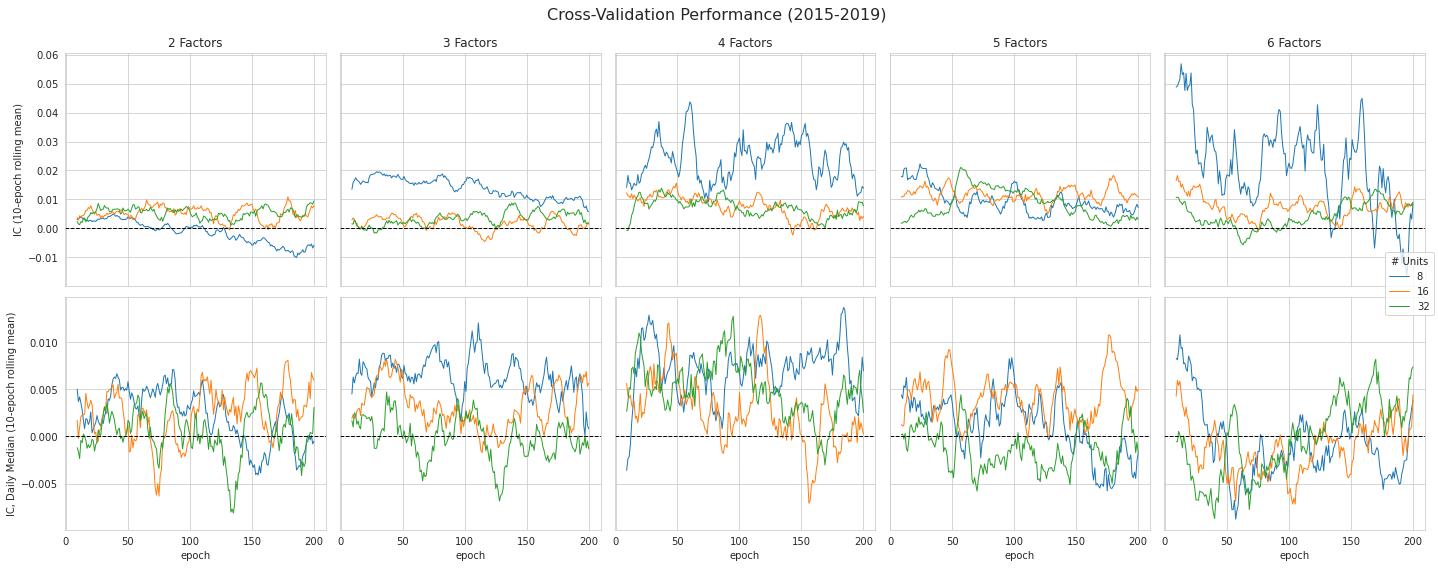

In [48]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 8), sharey='row', sharex=True)

for n in range(2, 7):
    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_mean')
    df.rolling(10).mean().loc[:200].plot(ax=axes[0][n-2], lw=1, title=f'{n} Factors')
    axes[0][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[0][n-2].get_legend().remove()
    axes[0][n-2].set_ylabel('IC (10-epoch rolling mean)')

    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_daily_median')
    df.rolling(10).mean().loc[:200].plot(ax=axes[1][n-2], lw=1)
    axes[1][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[1][n-2].get_legend().remove()
    axes[1][n-2].set_ylabel('IC, Daily Median (10-epoch rolling mean)')

handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', title='# Units')
fig.suptitle('Cross-Validation Performance (2015-2019)', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig(results_path / 'cv_performance', dpi=300);

## Generate Predictions

We'll average over a range of epochs that appears to deliver good predictions.

In [20]:
n_factors = 4
units = 32
batch_size = 32
first_epoch = 50
last_epoch = 80

In [21]:
len(list(range(first_epoch, last_epoch)))

30

In [22]:
predictions = []
for epoch in tqdm(list(range(first_epoch, last_epoch))):
    epoch_preds = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
        X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(data,
                                                                                  train_idx,
                                                                                  val_idx)

        model = make_model(n_factors=n_factors, hidden_units=units)
        model.fit([X1_train, X2_train], y_train,
                  batch_size=batch_size,
                  epochs=epoch,
                  verbose=0,
                  shuffle=True)
        epoch_preds.append(pd.Series(model.predict([X1_val, X2_val]).reshape(-1),
                                     index=y_val.stack().index).to_frame(epoch))

    predictions.append(pd.concat(epoch_preds))

  0%|          | 0/30 [00:00<?, ?it/s]

2/2 [==============================] - 0s 18ms/step


  3%|▎         | 1/30 [16:07<7:47:32, 967.34s/it]

2/2 [==============================] - 0s 16ms/step


  7%|▋         | 2/30 [32:31<7:35:58, 977.07s/it]

2/2 [==============================] - 0s 22ms/step


 10%|█         | 3/30 [1:09:30<11:34:50, 1544.08s/it]

2/2 [==============================] - 0s 14ms/step


 13%|█▎        | 4/30 [1:26:20<9:37:51, 1333.52s/it] 

2/2 [==============================] - 0s 15ms/step


 17%|█▋        | 5/30 [1:42:34<8:21:36, 1203.84s/it]

2/2 [==============================] - 0s 17ms/step


 20%|██        | 6/30 [2:00:51<7:46:58, 1167.44s/it]

2/2 [==============================] - 0s 18ms/step


 23%|██▎       | 7/30 [2:19:51<7:24:07, 1158.59s/it]

2/2 [==============================] - 0s 32ms/step


 27%|██▋       | 8/30 [2:38:08<6:57:35, 1138.87s/it]

2/2 [==============================] - 0s 15ms/step


 30%|███       | 9/30 [2:56:37<6:35:20, 1129.57s/it]

2/2 [==============================] - 0s 28ms/step


 33%|███▎      | 10/30 [3:15:28<6:16:39, 1129.98s/it]

2/2 [==============================] - 0s 15ms/step


 37%|███▋      | 11/30 [3:34:09<5:56:56, 1127.17s/it]

2/2 [==============================] - 0s 20ms/step


 37%|███▋      | 11/30 [3:45:12<6:29:00, 1228.45s/it]


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model_58/batch_norm/moments/sub' defined at (most recent call last):
    File "d:\Anacoda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "d:\Anacoda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "d:\Anacoda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "d:\Anacoda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "d:\Anacoda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "d:\Anacoda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "d:\Anacoda3\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "d:\Anacoda3\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "d:\Anacoda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "d:\Anacoda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "d:\Anacoda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "d:\Anacoda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "d:\Anacoda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "d:\Anacoda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "d:\Anacoda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "d:\Anacoda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "d:\Anacoda3\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "d:\Anacoda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "d:\Anacoda3\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "d:\Anacoda3\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "d:\Anacoda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\17485\AppData\Local\Temp/ipykernel_22512/1180813132.py", line 10, in <module>
      model.fit([X1_train, X2_train], y_train,
    File "d:\Anacoda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Anacoda3\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "d:\Anacoda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "d:\Anacoda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Anacoda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "d:\Anacoda3\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "d:\Anacoda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "d:\Anacoda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "d:\Anacoda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model_58/batch_norm/moments/sub'
OOM when allocating tensor with shape[32,3903,32] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node gradient_tape/model_58/batch_norm/moments/sub}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_393545]

In [24]:
predictions[0]

50
date       ticker          
2019-01-04 A       0.175388
           AA     -0.544257
           AADI    0.110260
           AAL     0.206020
           AAME    0.046429
...                     ...
2016-01-01 ZUO    -0.924199
           ZVRA   -2.725593
           ZWS     1.460255
           ZYME   -0.924199
           ZYXI   -0.201840

[1014780 rows x 1 columns]

In [25]:
pd.concat(predictions, axis=1).sort_index() 

50        51        52        53        54        55  \
date       ticker                                                               
2015-01-09 A       0.177837 -0.412726 -0.373906 -0.585444  0.312276 -0.005223   
           AA      0.547160 -0.334253 -0.258358 -0.392937  0.100227 -0.143948   
           AADI   -2.040370 -1.873960 -1.733164 -2.243789 -1.619313 -1.735657   
           AAL     0.420416 -0.105241  0.538808 -0.222950 -0.037651 -0.410689   
           AAME   -0.100307  0.076768 -0.042420  0.230957 -0.203271  0.012145   
...                     ...       ...       ...       ...       ...       ...   
2019-12-27 ZUO    -0.032322  0.153616 -0.523333  0.127212 -0.158179  0.083357   
           ZVRA    0.343636 -0.085219 -0.430639 -0.319276  0.244621 -0.016517   
           ZWS    -0.030453 -0.053211  0.498940  0.140129 -0.092054  0.067612   
           ZYME   -0.024848 -0.004047  0.105542 -0.099571  0.040427  0.107472   
           ZYXI   -0.138879  0.077738  0.495224 -0.353159  0.407938 -0.026855   

                         56        57        58        59        60  
date       ticker                                                    
2015-01-09 A       0.365469  0.125424 -0.047390 -0.079681 -0.203673  
           AA      0.284801  0.056588 -0.290262 -0.106150  0.271402  
           AADI   -2.055599 -2.048282 -1.908895 -1.839699 -1.789860  
           AAL     0.507833  0.234493 -0.477385  0.179808  0.273272  
           AAME   -0.072529 -0.022899  0.133136 -0.041234  0.070435  
...                     ...       ...       ...       ...       ...  
2019-12-27 ZUO    -0.004557  0.181024  0.213400 -0.105293  0.076835  
           ZVRA    0.021910 -0.183100 -0.080711 -0.403463 -0.069163  
           ZWS    -0.049151 -0.066402 -0.139575  0.161516  0.162237  
           ZYME    0.047888  0.223196  0.414178 -0.395517  0.125580  
           ZYXI    0.014164 -0.219744  0.056349  0.009269  0.331204  

[1014780 rows x 11 columns]

In [28]:
pd.concat(predictions, axis=1).sort_index().mean(axis=1).unstack('ticker').resample('W-FRI', level='date').last().stack().tz_localize('UTC', level='date').sort_index()

date                       ticker
2015-01-09 00:00:00+00:00  A        -0.066094
                           AA       -0.024157
                           AADI     -1.898962
                           AAL       0.081883
                           AAME      0.003707
                                       ...   
2019-12-27 00:00:00+00:00  ZUO       0.001069
                           ZVRA     -0.088902
                           ZWS       0.054508
                           ZYME      0.049118
                           ZYXI      0.059386
Length: 1014780, dtype: float32

In [51]:
predictions_combined = pd.concat(predictions, axis=1).sort_index()   

In [52]:
predictions_combined.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1149200 entries, (Timestamp('2015-01-09 00:00:00'), 'A') to (Timestamp('2019-12-27 00:00:00'), 'ZYXI')
Data columns (total 40 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   130     1149200 non-null  float32
 1   131     1149200 non-null  float32
 2   132     1149200 non-null  float32
 3   133     1149200 non-null  float32
 4   134     1149200 non-null  float32
 5   135     1149200 non-null  float32
 6   136     1149200 non-null  float32
 7   137     1149200 non-null  float32
 8   138     1149200 non-null  float32
 9   139     1149200 non-null  float32
 10  140     1149200 non-null  float32
 11  141     1149200 non-null  float32
 12  142     1149200 non-null  float32
 13  143     1149200 non-null  float32
 14  144     1149200 non-null  float32
 15  145     1149200 non-null  float32
 16  146     1149200 non-null  float32
 17  147     1149200 non-null  float32
 18  148     1149200 non-null  flo

In [53]:
predictions_combined.to_hdf(results_path / 'predictions.h5', 'predictions')

In [30]:
pd.concat(predictions, axis=1).to_hdf(results_path / 'predictions.h5', 'predictions_temp')
